# MED-PC Calculating Latencies

## Importing the Python Libraries

In [1]:
import sys
import glob
from collections import defaultdict
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from medpc2excel.medpc_read import medpc_read

In [3]:
# setting path
sys.path.append('../../src')

In [4]:
# All the libraries that were created for this repository
import extract.dataframe
import processing.tone
import extract.metadata

In [5]:
# Increase size of plot in jupyter

plt.rcParams["figure.figsize"] = (10,6)

## Loading in Recording and Metadata from Previous Notebook

In [6]:
metadata_df = pd.read_csv("./data/metadata_cage_1_2_3_4_date_20220503_20220512.csv", index_col=0)
concatted_medpc_df = pd.read_csv("./data/MEDPC_recording_cage_1_2_3_4_date_20220503_20220512.csv", index_col=0)
recording_and_metadata_df = pd.read_csv("./data/recording_and_metadata_cage_1_2_3_4_date_20220503_20220512.csv", index_col=0)

/tmp/ipykernel_183413/4127092493.py:3: DtypeWarning: Columns (10,16) have mixed types. Specify dtype option on import or set low_memory=False.
  recording_and_metadata_df = pd.read_csv("./data/recording_and_metadata_cage_1_2_3_4_date_20220503_20220512.csv", index_col=0)


- The Dataframe the contains the metadata(columns) of each recording file(rows)
    - We will mostly use this to get the cage number for each subject

In [7]:
metadata_df.head()

,index,File,Start Date,End Date,Subject,Experiment,Group,Box,Start Time,End Time,MSN,cage
0,./data/timestamp_dataframes/2022-05-06_12h59m_...,C:\MED-PC\Data\2022-05-06_12h59m_Subject 3.4 (...,05/06/22,05/06/22,3.4 (2),Pilot of Pilot,Cage 4,1,12:59:58,14:02:38,levelNP_CS_reward_laserepochON1st_noshock,4
1,./data/timestamp_dataframes/2022-05-06_08h37m_...,C:\MED-PC\Data\2022-05-06_08h37m_Subject 2.3.txt,05/06/22,05/06/22,2.3,Pilot of Pilot,Cage 1,1,08:37:09,09:53:25,levelNP_CS_reward_laserepochON1st_noshock,1
2,./data/timestamp_dataframes/2022-05-10_14h40m_...,C:\MED-PC\Data\2022-05-10_14h40m_Subject 4.3 (...,05/10/22,05/10/22,4.3 (3),Pilot of Pilot,Cage 4,2,14:40:24,15:43:18,levelNP_CS_reward_laserepochON1st_noshock,4
3,./data/timestamp_dataframes/2022-05-06_12h59m_...,C:\MED-PC\Data\2022-05-06_12h59m_Subject 4.3 (...,05/06/22,05/06/22,4.3 (3),Pilot of Pilot,Cage 4,2,12:59:58,14:02:38,levelNP_CS_reward_laserepochON1st_noshock,4
4,./data/timestamp_dataframes/2022-05-04_08h43m_...,C:\MED-PC\Data\2022-05-04_08h43m_Subject 2.3.txt,05/04/22,05/04/22,2.3,Pilot of Pilot,Cage 1,3,08:43:11,09:54:22,levelNP_CS_reward_laserepochON1st_noshock,1


- The Dataframe the contains the recording data for all the files.
    - The 1st row is the first data entries for each type of data(with the type being specified by the column label). This does not mean that all these are related or occured for the same trial. i.e. There can be many port entries and exits for a subject before and after a tone is played.
    - Each recording session will usually have a few thousand rows(although, most of of the columns will probably be blank by the end). And then after the last row of one session, the next row will be the next session with a different `file_path`

In [8]:
concatted_medpc_df.head()

,(P)Portentry,(Q)USdelivery,(R)UStime,(W)ITIvalues,(S)CSpresentation,(N)Portexit,(K)CStype,(B)shockintensity,date,subject,file_path
0,12.34,64.0,399.0,0.0,60.01,12.39,1.0,0.0,20220506,3.4 (2),./data/timestamp_dataframes/2022-05-06_12h59m_...
1,14.60,144.0,399.0,0.0,140.01,14.79,1.0,0.0,20220506,3.4 (2),./data/timestamp_dataframes/2022-05-06_12h59m_...
2,23.95,234.0,399.0,0.0,230.01,24.88,1.0,0.0,20220506,3.4 (2),./data/timestamp_dataframes/2022-05-06_12h59m_...
3,31.83,314.0,399.0,0.0,310.01,31.90,1.0,0.0,20220506,3.4 (2),./data/timestamp_dataframes/2022-05-06_12h59m_...
4,31.99,389.0,399.0,0.0,385.01,32.09,1.0,0.0,20220506,3.4 (2),./data/timestamp_dataframes/2022-05-06_12h59m_...


- This dataframe combines the recording data and metadata dataframes. This is done by using the subject ID as a common column to merge together off of.

In [9]:
recording_and_metadata_df.head()

,(P)Portentry,(Q)USdelivery,(R)UStime,(W)ITIvalues,(S)CSpresentation,(N)Portexit,(K)CStype,(B)shockintensity,date,subject,...,Start Date,End Date,Subject,Experiment,Group,Box,Start Time,End Time,MSN,cage
0,12.34,64.0,399.0,0.0,60.01,12.39,1.0,0.0,20220506,3.4 (2),...,05/06/22,05/06/22,3.4 (2),Pilot of Pilot,Cage 4,1,12:59:58,14:02:38,levelNP_CS_reward_laserepochON1st_noshock,4
1,14.60,144.0,399.0,0.0,140.01,14.79,1.0,0.0,20220506,3.4 (2),...,05/06/22,05/06/22,3.4 (2),Pilot of Pilot,Cage 4,1,12:59:58,14:02:38,levelNP_CS_reward_laserepochON1st_noshock,4
2,23.95,234.0,399.0,0.0,230.01,24.88,1.0,0.0,20220506,3.4 (2),...,05/06/22,05/06/22,3.4 (2),Pilot of Pilot,Cage 4,1,12:59:58,14:02:38,levelNP_CS_reward_laserepochON1st_noshock,4
3,31.83,314.0,399.0,0.0,310.01,31.90,1.0,0.0,20220506,3.4 (2),...,05/06/22,05/06/22,3.4 (2),Pilot of Pilot,Cage 4,1,12:59:58,14:02:38,levelNP_CS_reward_laserepochON1st_noshock,4
4,31.99,389.0,399.0,0.0,385.01,32.09,1.0,0.0,20220506,3.4 (2),...,05/06/22,05/06/22,3.4 (2),Pilot of Pilot,Cage 4,1,12:59:58,14:02:38,levelNP_CS_reward_laserepochON1st_noshock,4


## Getting the First Port Entry After Each Tone

- Getting all the rows that correspond to one of the files paths. This will be the equivalent of getting all the rows for one session

In [10]:
example_one_session_recording_df = recording_and_metadata_df[recording_and_metadata_df["file_path"] == recording_and_metadata_df["file_path"].unique()[0]
]

- Everything looks normal enough

In [11]:
example_one_session_recording_df.head()

,(P)Portentry,(Q)USdelivery,(R)UStime,(W)ITIvalues,(S)CSpresentation,(N)Portexit,(K)CStype,(B)shockintensity,date,subject,...,Start Date,End Date,Subject,Experiment,Group,Box,Start Time,End Time,MSN,cage
0,12.34,64.0,399.0,0.0,60.01,12.39,1.0,0.0,20220506,3.4 (2),...,05/06/22,05/06/22,3.4 (2),Pilot of Pilot,Cage 4,1,12:59:58,14:02:38,levelNP_CS_reward_laserepochON1st_noshock,4
1,14.60,144.0,399.0,0.0,140.01,14.79,1.0,0.0,20220506,3.4 (2),...,05/06/22,05/06/22,3.4 (2),Pilot of Pilot,Cage 4,1,12:59:58,14:02:38,levelNP_CS_reward_laserepochON1st_noshock,4
2,23.95,234.0,399.0,0.0,230.01,24.88,1.0,0.0,20220506,3.4 (2),...,05/06/22,05/06/22,3.4 (2),Pilot of Pilot,Cage 4,1,12:59:58,14:02:38,levelNP_CS_reward_laserepochON1st_noshock,4
3,31.83,314.0,399.0,0.0,310.01,31.90,1.0,0.0,20220506,3.4 (2),...,05/06/22,05/06/22,3.4 (2),Pilot of Pilot,Cage 4,1,12:59:58,14:02:38,levelNP_CS_reward_laserepochON1st_noshock,4
4,31.99,389.0,399.0,0.0,385.01,32.09,1.0,0.0,20220506,3.4 (2),...,05/06/22,05/06/22,3.4 (2),Pilot of Pilot,Cage 4,1,12:59:58,14:02:38,levelNP_CS_reward_laserepochON1st_noshock,4


- `(S)CSpresentation` is the time that the tone starts playing. MED-PC starts inputting in random numbers that are in the 1000's. So we will remove these

In [12]:
example_one_session_recording_df[50:60]

,(P)Portentry,(Q)USdelivery,(R)UStime,(W)ITIvalues,(S)CSpresentation,(N)Portexit,(K)CStype,(B)shockintensity,date,subject,...,Start Date,End Date,Subject,Experiment,Group,Box,Start Time,End Time,MSN,cage
50,438.69,NaN,NaN,0.0,9000.0,439.62,0.0,0.0,20220506,3.4 (2),...,05/06/22,05/06/22,3.4 (2),Pilot of Pilot,Cage 4,1,12:59:58,14:02:38,levelNP_CS_reward_laserepochON1st_noshock,4
51,446.71,NaN,NaN,0.0,12000.0,447.92,0.0,0.0,20220506,3.4 (2),...,05/06/22,05/06/22,3.4 (2),Pilot of Pilot,Cage 4,1,12:59:58,14:02:38,levelNP_CS_reward_laserepochON1st_noshock,4
52,452.60,NaN,NaN,0.0,9000.0,453.28,0.0,0.0,20220506,3.4 (2),...,05/06/22,05/06/22,3.4 (2),Pilot of Pilot,Cage 4,1,12:59:58,14:02:38,levelNP_CS_reward_laserepochON1st_noshock,4
53,460.11,NaN,NaN,0.0,8500.0,461.21,0.0,0.0,20220506,3.4 (2),...,05/06/22,05/06/22,3.4 (2),Pilot of Pilot,Cage 4,1,12:59:58,14:02:38,levelNP_CS_reward_laserepochON1st_noshock,4
54,464.04,NaN,NaN,0.0,9000.0,464.49,0.0,0.0,20220506,3.4 (2),...,05/06/22,05/06/22,3.4 (2),Pilot of Pilot,Cage 4,1,12:59:58,14:02:38,levelNP_CS_reward_laserepochON1st_noshock,4
55,475.64,NaN,NaN,0.0,9500.0,476.41,0.0,0.0,20220506,3.4 (2),...,05/06/22,05/06/22,3.4 (2),Pilot of Pilot,Cage 4,1,12:59:58,14:02:38,levelNP_CS_reward_laserepochON1st_noshock,4
56,484.23,NaN,NaN,0.0,12000.0,484.53,0.0,0.0,20220506,3.4 (2),...,05/06/22,05/06/22,3.4 (2),Pilot of Pilot,Cage 4,1,12:59:58,14:02:38,levelNP_CS_reward_laserepochON1st_noshock,4
57,487.74,NaN,NaN,0.0,8000.0,489.12,0.0,0.0,20220506,3.4 (2),...,05/06/22,05/06/22,3.4 (2),Pilot of Pilot,Cage 4,1,12:59:58,14:02:38,levelNP_CS_reward_laserepochON1st_noshock,4
58,495.85,NaN,NaN,0.0,9500.0,499.31,0.0,0.0,20220506,3.4 (2),...,05/06/22,05/06/22,3.4 (2),Pilot of Pilot,Cage 4,1,12:59:58,14:02:38,levelNP_CS_reward_laserepochON1st_noshock,4
59,505.47,NaN,NaN,0.0,8000.0,507.17,0.0,0.0,20220506,3.4 (2),...,05/06/22,05/06/22,3.4 (2),Pilot of Pilot,Cage 4,1,12:59:58,14:02:38,levelNP_CS_reward_laserepochON1st_noshock,4


- `(S)CSpresentation` then starts adding blanks(NaN) so we will remove these too

In [13]:
example_one_session_recording_df.tail()

,(P)Portentry,(Q)USdelivery,(R)UStime,(W)ITIvalues,(S)CSpresentation,(N)Portexit,(K)CStype,(B)shockintensity,date,subject,...,Start Date,End Date,Subject,Experiment,Group,Box,Start Time,End Time,MSN,cage
2536,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,20220506,3.4 (2),...,05/06/22,05/06/22,3.4 (2),Pilot of Pilot,Cage 4,1,12:59:58,14:02:38,levelNP_CS_reward_laserepochON1st_noshock,4
2537,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,20220506,3.4 (2),...,05/06/22,05/06/22,3.4 (2),Pilot of Pilot,Cage 4,1,12:59:58,14:02:38,levelNP_CS_reward_laserepochON1st_noshock,4
2538,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,20220506,3.4 (2),...,05/06/22,05/06/22,3.4 (2),Pilot of Pilot,Cage 4,1,12:59:58,14:02:38,levelNP_CS_reward_laserepochON1st_noshock,4
2539,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,20220506,3.4 (2),...,05/06/22,05/06/22,3.4 (2),Pilot of Pilot,Cage 4,1,12:59:58,14:02:38,levelNP_CS_reward_laserepochON1st_noshock,4
2540,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,20220506,3.4 (2),...,05/06/22,05/06/22,3.4 (2),Pilot of Pilot,Cage 4,1,12:59:58,14:02:38,levelNP_CS_reward_laserepochON1st_noshock,4


- Getting the tones that were actually used for the recordings

In [14]:
example_one_session_valid_tones = processing.tone.get_valid_tones(example_one_session_recording_df["(S)CSpresentation"])

In [15]:
example_one_session_valid_tones

0       60.01
1      140.01
2      230.01
3      310.01
4      385.01
5      485.01
6      580.01
7      670.01
8      750.01
9      840.01
10     940.01
11    1030.01
12    1150.01
13    1240.01
14    1325.01
15    1415.01
16    1510.01
17    1630.01
18    1710.01
19    1805.01
20    1885.01
21    1975.01
22    2055.01
23    2130.01
24    2230.01
25    2325.01
26    2415.01
27    2495.01
28    2585.01
29    2685.01
30    2775.01
31    2895.01
32    2985.01
33    3070.01
34    3160.01
35    3255.01
36    3345.01
37    3425.01
38    3515.01
39    3615.01
Name: (S)CSpresentation, dtype: float64

- With these tone playing times, we will get the first port entry that comes after the tone playing time
    - This was done by getting all the port entries that came after the tone. And then getting the port entry time that was earliest in time(aka smallest number)

In [16]:
processing.tone.get_first_port_entries(tone_pd_series=example_one_session_valid_tones, port_entries_pd_series=example_one_session_recording_df["(P)Portentry"])

,current_tone_time,first_port_entry_after_tone
0,60.01,69.00
1,140.01,148.27
2,230.01,231.91
3,310.01,320.97
4,385.01,394.75
5,485.01,487.74
6,580.01,584.00
7,670.01,676.26
8,750.01,777.83
9,840.01,840.06


- Getting the first port entry times for all the sessions

In [17]:
concatted_first_porty_entry_dataframe = processing.tone.get_concatted_first_porty_entry_dataframe(concatted_medpc_df=concatted_medpc_df)

In [18]:
concatted_first_porty_entry_dataframe

,current_tone_time,first_port_entry_after_tone,file_path,date,subject
0,60.01,69.00,./data/timestamp_dataframes/2022-05-06_12h59m_...,20220506,3.4 (2)
1,140.01,148.27,./data/timestamp_dataframes/2022-05-06_12h59m_...,20220506,3.4 (2)
2,230.01,231.91,./data/timestamp_dataframes/2022-05-06_12h59m_...,20220506,3.4 (2)
3,310.01,320.97,./data/timestamp_dataframes/2022-05-06_12h59m_...,20220506,3.4 (2)
4,385.01,394.75,./data/timestamp_dataframes/2022-05-06_12h59m_...,20220506,3.4 (2)
...,...,...,...,...,...
6224,3160.01,3161.89,./data/timestamp_dataframes/2022-05-08_11h14m_...,20220508,1.3
6225,3255.01,3255.09,./data/timestamp_dataframes/2022-05-08_11h14m_...,20220508,1.3
6226,3345.01,3351.67,./data/timestamp_dataframes/2022-05-08_11h14m_...,20220508,1.3
6227,3425.01,3431.15,./data/timestamp_dataframes/2022-05-08_11h14m_...,20220508,1.3


## Getting the Latency for Each Session of a Tone Playing

- To calculate latency, we would just subtract the time of the first port entry to that of the tone playing

In [19]:
concatted_first_porty_entry_dataframe["latency"] = concatted_first_porty_entry_dataframe["first_port_entry_after_tone"] - concatted_first_porty_entry_dataframe["current_tone_time"]

In [20]:
concatted_first_porty_entry_dataframe.head()

,current_tone_time,first_port_entry_after_tone,file_path,date,subject,latency
0,60.01,69.00,./data/timestamp_dataframes/2022-05-06_12h59m_...,20220506,3.4 (2),8.99
1,140.01,148.27,./data/timestamp_dataframes/2022-05-06_12h59m_...,20220506,3.4 (2),8.26
2,230.01,231.91,./data/timestamp_dataframes/2022-05-06_12h59m_...,20220506,3.4 (2),1.90
3,310.01,320.97,./data/timestamp_dataframes/2022-05-06_12h59m_...,20220506,3.4 (2),10.96
4,385.01,394.75,./data/timestamp_dataframes/2022-05-06_12h59m_...,20220506,3.4 (2),9.74


- For all the latencies that are are greater than 30 seconds, we changed the latency to 30 seconds

In [21]:
concatted_first_porty_entry_dataframe["latency_adjusted"] = concatted_first_porty_entry_dataframe["latency"].apply(lambda x: 30 if x >= 30 else x)

In [22]:
concatted_first_porty_entry_dataframe[concatted_first_porty_entry_dataframe["latency"] >= 30].head()

,current_tone_time,first_port_entry_after_tone,file_path,date,subject,latency,latency_adjusted
12,1150.01,1224.44,./data/timestamp_dataframes/2022-05-06_12h59m_...,20220506,3.4 (2),74.43,30.0
23,2130.01,2192.23,./data/timestamp_dataframes/2022-05-06_12h59m_...,20220506,3.4 (2),62.22,30.0
109,2585.01,2615.82,./data/timestamp_dataframes/2022-05-10_14h40m_...,20220510,4.3 (3),30.81,30.0
132,940.01,982.59,./data/timestamp_dataframes/2022-05-06_12h59m_...,20220506,4.3 (3),42.58,30.0
154,2985.01,3023.64,./data/timestamp_dataframes/2022-05-06_12h59m_...,20220506,4.3 (3),38.63,30.0


- Getting all the latencies that are less than 10 seconds. If it is, we'll label it as 1 and 0 if not

In [23]:
concatted_first_porty_entry_dataframe["latency_less_than_10_seconds"] = concatted_first_porty_entry_dataframe["latency"].apply(lambda x: 1 if x <= 10 else 0)

In [24]:
concatted_first_porty_entry_dataframe.head()

,current_tone_time,first_port_entry_after_tone,file_path,date,subject,latency,latency_adjusted,latency_less_than_10_seconds
0,60.01,69.00,./data/timestamp_dataframes/2022-05-06_12h59m_...,20220506,3.4 (2),8.99,8.99,1
1,140.01,148.27,./data/timestamp_dataframes/2022-05-06_12h59m_...,20220506,3.4 (2),8.26,8.26,1
2,230.01,231.91,./data/timestamp_dataframes/2022-05-06_12h59m_...,20220506,3.4 (2),1.90,1.90,1
3,310.01,320.97,./data/timestamp_dataframes/2022-05-06_12h59m_...,20220506,3.4 (2),10.96,10.96,0
4,385.01,394.75,./data/timestamp_dataframes/2022-05-06_12h59m_...,20220506,3.4 (2),9.74,9.74,1


## Making Dataframes that have Each Subject as the Row and Each Date as the Column

- Pivot plots allow us to make columns out of each unique entry in a selected column. (For this, it will be the date column that we will turn into columns) The index for the rows will be each unique entry in another column. (For this, it will be the subject's ID) And the values will be the aggregate of the values that have both the values in the previous two selected columns. (For this it will be the latency columns and we will take the mean)
    - https://pandas.pydata.org/docs/reference/api/pandas.pivot_table.html

- Making a pivot plot with the regular latency

In [25]:
all_latency_pivot_plot = pd.pivot_table(concatted_first_porty_entry_dataframe, values='latency', index=['subject'],

                    columns=['date'], aggfunc=np.mean)


- Getting the cage numbers for each subject and then making a dictionary out of it
    - This will be used to add the cage information to the pivot plots

In [26]:
subject_to_cage = pd.Series(metadata_df["cage"].values,index=metadata_df["Subject"].values).to_dict()

In [27]:
subject_to_cage

{'3.4 (2)': 4,
 '2.3': 1,
 '4.3 (3)': 4,
 '2.1': 2,
 '1.2': 2,
 '1.1': 1,
 '1.3': 2,
 '2.4': 2,
 '4.1 (1)': 3,
 '4.4 (4)': 4,
 '3.3 (4)': 3,
 '3.2 (2)': 3,
 '1.4': 1,
 '3.1 (1)': 4,
 '2.2': 1,
 '4.2 (3)': 3}

In [28]:
all_latency_pivot_plot.head()

date,20220503,20220504,20220505,20220506,20220507,20220508,20220509,20220510,20220511,20220512
subject,,,,,,,,,,
1.1,42.218000,6.046829,11.537750,5.956341,3.59800,10.863590,7.18400,6.876750,9.92700,NaN
1.2,49.817857,25.471538,13.112195,7.628250,5.64800,4.987692,4.09525,9.064000,6.92650,18.89000
1.3,86.598000,36.300526,373.844750,14.234500,7.00100,8.922821,8.97225,8.345250,7.85100,16.60550
1.4,61.345333,10.832683,125.872000,29.977805,12.33400,6.594103,5.93475,8.869625,19.38650,NaN
2.1,30.953125,7.548500,18.269268,5.618500,3.92925,6.335897,5.16775,6.824000,4.94175,17.10825


- Adding the cage information with the dictionary

In [29]:
all_latency_pivot_plot["cage"] = all_latency_pivot_plot.index.map(subject_to_cage)

In [30]:
all_latency_pivot_plot.head()

date,20220503,20220504,20220505,20220506,20220507,20220508,20220509,20220510,20220511,20220512,cage
subject,,,,,,,,,,,
1.1,42.218000,6.046829,11.537750,5.956341,3.59800,10.863590,7.18400,6.876750,9.92700,NaN,1
1.2,49.817857,25.471538,13.112195,7.628250,5.64800,4.987692,4.09525,9.064000,6.92650,18.89000,2
1.3,86.598000,36.300526,373.844750,14.234500,7.00100,8.922821,8.97225,8.345250,7.85100,16.60550,2
1.4,61.345333,10.832683,125.872000,29.977805,12.33400,6.594103,5.93475,8.869625,19.38650,NaN,1
2.1,30.953125,7.548500,18.269268,5.618500,3.92925,6.335897,5.16775,6.824000,4.94175,17.10825,2


In [31]:
all_latency_pivot_plot.to_csv("./data/all_latency_pivot_plot_cage_1_2_3_4_date_20220503_20220512.csv")
all_latency_pivot_plot.to_excel("./data/all_latency_pivot_plot_cage_1_2_3_4_date_20220503_20220512.xlsx")

- Doing the same thing for the adjust latency

In [32]:
adjusted_latency_pivot_plot = pd.pivot_table(concatted_first_porty_entry_dataframe, values='latency_adjusted', index=['subject'],

                    columns=['date'], aggfunc=np.mean)


In [33]:
adjusted_latency_pivot_plot["cage"] = adjusted_latency_pivot_plot.index.map(subject_to_cage)

In [34]:
adjusted_latency_pivot_plot.head()

date,20220503,20220504,20220505,20220506,20220507,20220508,20220509,20220510,20220511,20220512,cage
subject,,,,,,,,,,,
1.1,19.980000,6.046829,9.446750,5.956341,3.59800,10.670769,7.18400,6.862375,9.92350,NaN,1
1.2,27.120000,17.573077,11.960732,7.628250,5.64800,4.987692,4.09525,7.562000,6.92650,16.95725,2
1.3,27.746000,21.131316,26.896000,10.405250,6.65950,8.282564,7.27000,8.273500,7.78250,15.18050,2
1.4,22.285333,10.832683,24.336000,12.144634,9.19425,6.594103,5.93475,8.779250,14.12675,NaN,1
2.1,17.701875,7.473000,10.245122,5.289500,3.92925,5.700256,5.16775,6.824000,4.94175,15.18450,2


In [35]:
adjusted_latency_pivot_plot.to_csv("./data/adjusted_latency_pivot_plot_cage_1_2_3_4_date_20220503_20220512.csv")
adjusted_latency_pivot_plot.to_excel("./data/adjusted_latency_pivot_plot_cage_1_2_3_4_date_20220503_20220512.xlsx")

- Doing the same for the ratio of latencies that are less than 10 seconds

In [36]:
less_than_10_latency_df = pd.pivot_table(concatted_first_porty_entry_dataframe, values='latency_less_than_10_seconds', index=['subject'],

                    columns=['date'], aggfunc=np.mean)


In [37]:
less_than_10_latency_df["cage"] = less_than_10_latency_df.index.map(subject_to_cage)

In [38]:
less_than_10_latency_df

date,20220503,20220504,20220505,20220506,20220507,20220508,20220509,20220510,20220511,20220512,cage
subject,,,,,,,,,,,
1.1,0.333333,0.780488,0.675000,0.829268,0.975,0.589744,0.725,0.687500,0.500,NaN,1
1.2,0.062500,0.400000,0.487805,0.675000,0.925,0.923077,0.950,0.775000,0.800,0.325,2
1.3,0.000000,0.225000,0.073171,0.600000,0.825,0.717949,0.700,0.725000,0.700,0.450,2
1.4,0.200000,0.487805,0.025000,0.512195,0.600,0.769231,0.825,0.587500,0.425,NaN,1
2.1,0.235294,0.775000,0.658537,0.875000,0.925,0.820513,0.775,0.600000,0.775,0.400,2
2.2,0.200000,0.487805,0.750000,0.804878,0.925,0.820513,0.675,0.662500,0.300,NaN,1
2.3,0.066667,0.487805,0.725000,0.902439,0.900,0.923077,0.925,0.837500,0.750,NaN,1
2.4,0.250000,0.275000,0.536585,0.675000,0.850,0.923077,1.000,0.875000,0.900,0.800,2
3.1 (1),0.675000,0.780488,0.800000,0.825000,0.900,0.897436,0.950,0.853659,0.925,0.925,4


In [39]:
less_than_10_latency_df.to_csv("./data/less_than_10_seconds_latencies_cage_1_2_3_4_date_20220503_20220512.csv")
less_than_10_latency_df.to_excel("./data/less_than_10_seconds_latencies_cage_1_2_3_4_date_20220503_20220512.xlsx")

## Plotting the latencies

- We will plot a line for each subject. With the X-axis being the days since the first session. And the Y-axis is the latency values averaged across all the trials for one recording session
- Grouping all the rows with the same subject and date(aka, all the trials in one session). And then getting the mean for each value

In [40]:
grouped_averaged_first_porty_entry_dataframe = concatted_first_porty_entry_dataframe.groupby(["subject", "date"]).mean()

In [41]:
grouped_averaged_first_porty_entry_dataframe.head()

current_tone_time  first_port_entry_after_tone    latency  \
subject date                                                                  
1.1     20220503         675.676667                   717.894667  42.218000   
        20220504        1871.473415                  1877.520244   6.046829   
        20220505        1825.635000                  1837.172750  11.537750   
        20220506        1871.473415                  1877.429756   5.956341   
        20220507        1825.635000                  1829.233000   3.598000   

                  latency_adjusted  latency_less_than_10_seconds  
subject date                                                      
1.1     20220503         19.980000                      0.333333  
        20220504          6.046829                      0.780488  
        20220505          9.446750                      0.675000  
        20220506          5.956341                      0.829268  
        20220507          3.598000                      0.975000

- Resetting the index so that we can use the data as a value

In [42]:
grouped_averaged_first_porty_entry_dataframe = grouped_averaged_first_porty_entry_dataframe.reset_index()

In [43]:
grouped_averaged_first_porty_entry_dataframe.head()

,subject,date,current_tone_time,first_port_entry_after_tone,latency,latency_adjusted,latency_less_than_10_seconds
0,1.1,20220503,675.676667,717.894667,42.218000,19.980000,0.333333
1,1.1,20220504,1871.473415,1877.520244,6.046829,6.046829,0.780488
2,1.1,20220505,1825.635000,1837.172750,11.537750,9.446750,0.675000
3,1.1,20220506,1871.473415,1877.429756,5.956341,5.956341,0.829268
4,1.1,20220507,1825.635000,1829.233000,3.598000,3.598000,0.975000


- Turning the date column which is a string, into an integer
    - This will allow us to use the date as the X-axis for plotting

In [44]:
grouped_averaged_first_porty_entry_dataframe["date_int"] = grouped_averaged_first_porty_entry_dataframe["date"].astype(int)

In [45]:
grouped_averaged_first_porty_entry_dataframe.head()

,subject,date,current_tone_time,first_port_entry_after_tone,latency,latency_adjusted,latency_less_than_10_seconds,date_int
0,1.1,20220503,675.676667,717.894667,42.218000,19.980000,0.333333,20220503
1,1.1,20220504,1871.473415,1877.520244,6.046829,6.046829,0.780488,20220504
2,1.1,20220505,1825.635000,1837.172750,11.537750,9.446750,0.675000,20220505
3,1.1,20220506,1871.473415,1877.429756,5.956341,5.956341,0.829268,20220506
4,1.1,20220507,1825.635000,1829.233000,3.598000,3.598000,0.975000,20220507


- Adding the cage information
    - We will make one plot for each cage

In [46]:
grouped_averaged_first_porty_entry_dataframe["cage"] = grouped_averaged_first_porty_entry_dataframe["subject"].map(subject_to_cage)

In [47]:
grouped_averaged_first_porty_entry_dataframe.head()

,subject,date,current_tone_time,first_port_entry_after_tone,latency,latency_adjusted,latency_less_than_10_seconds,date_int,cage
0,1.1,20220503,675.676667,717.894667,42.218000,19.980000,0.333333,20220503,1
1,1.1,20220504,1871.473415,1877.520244,6.046829,6.046829,0.780488,20220504,1
2,1.1,20220505,1825.635000,1837.172750,11.537750,9.446750,0.675000,20220505,1
3,1.1,20220506,1871.473415,1877.429756,5.956341,5.956341,0.829268,20220506,1
4,1.1,20220507,1825.635000,1829.233000,3.598000,3.598000,0.975000,20220507,1


- Plotting the adjusted latency

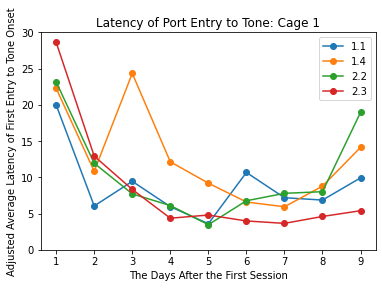

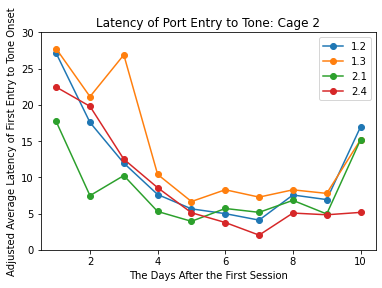

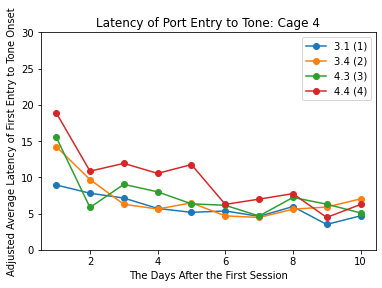

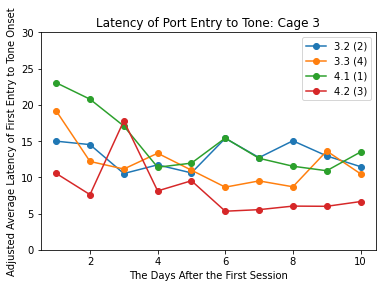

In [48]:
# Plotting for each cage
for cage in grouped_averaged_first_porty_entry_dataframe["cage"].unique():
    fig, ax = plt.subplots()
    # Getting all the rows with the current cage number
    cage_df = grouped_averaged_first_porty_entry_dataframe[grouped_averaged_first_porty_entry_dataframe["cage"] == cage]
    
    # Plotting a line for each subject
    for subject in cage_df["subject"].unique():
        # Getting all the rows with the current subject
        subject_df = cage_df[cage_df["subject"] == subject]
        # Making the dates into days after the first session by subtracting all the dates by the first date
        ax.plot(subject_df["date_int"] - subject_df["date_int"].min() + 1, subject_df["latency_adjusted"], '-o', label=subject)

    # Setting the Y-Axis to only plot from 0 to 30 because we adjusted the latency to always be under 30
    ax.set_ylim(0, 30)
    # Labeling the X/Y Axis and the title
    ax.set_xlabel("The Days After the First Session")
    ax.set_ylabel("Adjusted Average Latency of First Entry to Tone Onset")
    ax.set_title("Latency of Port Entry to Tone: Cage {}".format(cage))
    # To show the legend
    ax.legend()
    plt.savefig("./data/plots/average_latency_plots/average_port_entry_latency_cage_{}_date_20220503_20220512.png".format(cage))    

- Plotting the ratio of latencies that are less than 10 seconds

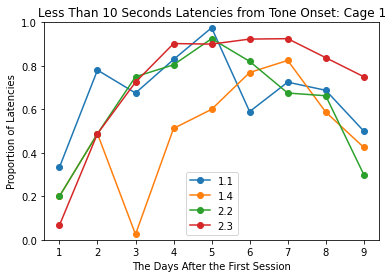

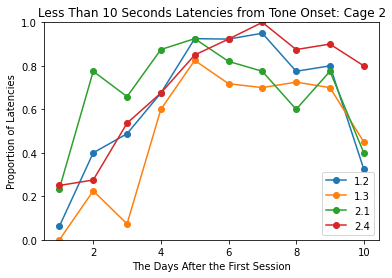

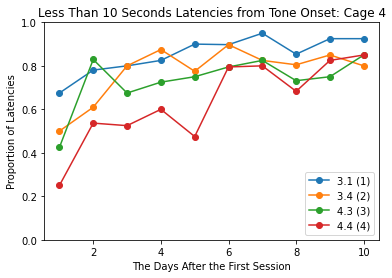

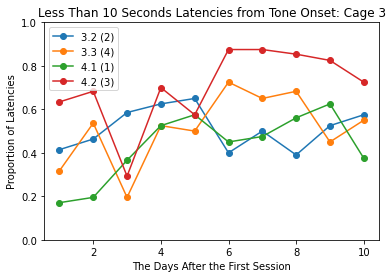

In [49]:
# Plotting for each cage
for cage in grouped_averaged_first_porty_entry_dataframe["cage"].unique():
    fig, ax = plt.subplots()
    # Getting all the rows with the current cage number
    cage_df = grouped_averaged_first_porty_entry_dataframe[grouped_averaged_first_porty_entry_dataframe["cage"] == cage]
    
    # Plotting a line for each subject
    for subject in cage_df["subject"].unique():
        # Getting all the rows with the current subject
        subject_df = cage_df[cage_df["subject"] == subject]
        # Making the dates into days after the first session by subtracting all the dates by the first date
        ax.plot(subject_df["date_int"] - subject_df["date_int"].min() + 1, subject_df["latency_less_than_10_seconds"], '-o', label=subject)

    # Setting the Y-Axis to only plot from 0 to 30 because we adjusted the latency to always be under 30
    ax.set_ylim(0, 1)
    # Labeling the X/Y Axis and the title
    ax.set_xlabel("The Days After the First Session")
    ax.set_ylabel("Proportion of Latencies")
    ax.set_title("Less Than 10 Seconds Latencies from Tone Onset: Cage {}".format(cage))
    # To show the legend
    ax.legend()
    plt.savefig("./data/plots/proportion_of_latencies_less_than_10_seconds/less_than_10_seconds_latency_proportion_cage_{}_date_20220503_20220512.png".format(cage))
